# PID - Comment ça marche ?

Le but de ce Notebook est de vous guider à travers quelques simulations pour vous donner une compréhension intuitive du fonctionnement d'un PID.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Implémentation

Le première étape consiste à implémenter un PID. 

$$Control = K_p \cdot e(t) + K_i \cdot \int_t e(t) dt + K_d \cdot \frac {de(t)}{dt}$$

In [39]:
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.previous_error = 0
        self.integral = 0
        
    def get_control(self, setpoint, measure, dt):
        error = setpoint - measure
        derivative = error - self.previous_error
        self.previous_error = error
        self.integral += error
        return self.Kp * error + self.Kd * derivative + self.Ki * self.integral

## Simulation

On considère un objet à une dimension : la température du four, l'angle d'inclinaison du drone, la distance avec la voiture qui précède...  
Le modèle simule la physique de cette dimension. On peut en général les écrire sous forme d'équations différentielles.

En automatique, on retrouve beaucoup deux classes de modèles : les premiers et les deuxièmes ordres. Il s'agit de modèle dont les équations différentielles sont des équations linéaires du premier et deuxième ordre.

Premier ordre : $$\tau \frac {ds(t)}{dt} + s(t) = control(t)$$

Second ordre : $$\frac {1}{\omega^2} \frac {d^2s(t)}{dt^2} + \frac {2 \epsilon}{\omega} \frac{ds(t)}{dt} + s(t) = control(t)$$

In [3]:
class Model:
    def update(self, control, dt):
        return 1

In [4]:
class ZeroOrderModel(Model):
    def __init__(self):
        self.value = 0
    
    def update(self, control, dt):
        self.value += control * dt
        return self.value

In [146]:
class FirstOrderModel(Model):
    def __init__(self):
        self.value = 0
        self.tau = 2  # Response time
    
    def update(self, control, dt):
        speed = (control - self.value) / self.tau
        self.value += speed * dt
        return self.value

In [287]:
class SecondOrderModel(Model):
    def __init__(self, omega = 0.2, epsilon = 0.1):
        self.value = 0
        self.speed = 0
        self.omega = omega
        self.epsilon = epsilon
    
    def update(self, control, dt):
        acceleration = self.omega ** 2 * (control - self.value) - 2 * self.epsilon * self.omega * self.speed
        self.speed += acceleration * dt
        self.value += self.speed * dt
        return self.value

In [7]:
def run_simulation(model: Model, controller: PID, setpoint=1, iterations=1000):
    measure = 0
    dt = 0.1
    measures = []
    
    for i in range(iterations):
        control = controller.get_control(setpoint, measure, dt)
        measure = model.update(control, dt)
        measures.append(measure)
    return measures

## Premier ordre

Essayez de trouver la convergence la plus rapide pour ce premier ordre, en jouant sur les paramètres du `PID`. Quelle est l'influence de Kp ? Ki ? Kd ?

In [348]:
measures = run_simulation(FirstOrderModel(), PID(1., 0, 0.))

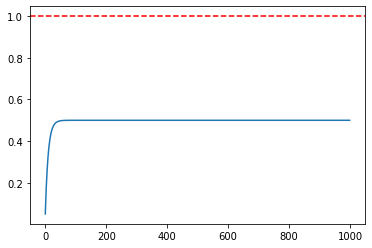

In [349]:
plt.plot(measures)
plt.axhline(1, color='red', linestyle='--')

Un détail important : essayez Kp=1, Ki = Kd = 0. Vous constaterez que le système converge, mais vers la mauvaise valeur. On appelle cela la **steady state error**, et c'est une des raisons du terme intégral. En effet, en ajoutant l'intégral, ce terme va augmenter jusqu'à ce que l'erreur devienne nulle.

Intuitivement, cette situation survient lorsqu'il faut maintenir un effor constant pour garder une position.
  
Par exemple en cas de vent, le drone ne va pas converger vers sa position désirée. De même, si on place le robot sur une pente, il sera incapable de garder sa position s'il n'a pas de terme intégral.

## Deuxième ordre

Essayez de trouver la convergence la plus rapide pour un second ordre, tout en maintenant des oscillations faibles.

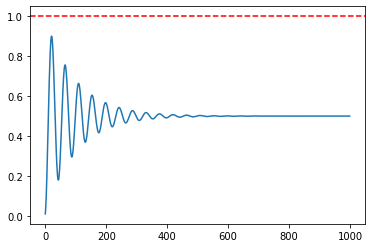

In [324]:
plt.plot(run_simulation(SecondOrderModel(omega=1, epsilon=0.1), PID(1, 0.0, 0.)))
plt.axhline(1, color='red', linestyle='--')

## Robustesse

On parle de robustesse quand notre solution fonctionne encore lorsque l'on change certains paramètres. Est ce que le drone est toujours stable si on lui ajoute du poids ? S'il y a du délai dans l'exécution des commandes ?

Une visualisation parlante est de tracer la zone de stabilité d'un modèle, en fonction de certains paramètres.

In [350]:
class FirstOrderModelWithDelay(Model):
    def __init__(self, tau = 2, delay = 0.5):
        self.tau = tau
        self.delay = delay
        self.value = 0
        self._control_history = []

    
    def update(self, control, dt):
        self._control_history.insert(0, control)
        if len(self._control_history) <= self.delay / dt:
            control = 0
        else:
            control = self._control_history[int(self.delay / dt)]
            self._control_history.pop()
        speed = (control - self.value) * dt / self.tau
        self.value += speed * dt
        return self.value

In [351]:
def is_stable(kp, ki, kd, tau, delay):
    measures = run_simulation(FirstOrderModelWithDelay(tau, delay), PID(kp, ki, kd))
    #print(np.array(measures)[-10:])
    return np.all(np.abs(np.array(measures)[-10:] - 1) < 1e-2)

### Visualisons la stabilité

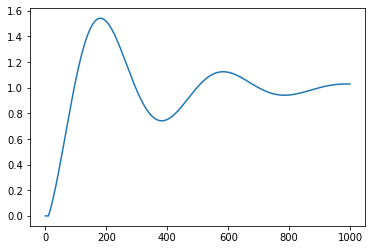

In [352]:
plt.plot(run_simulation(FirstOrderModelWithDelay(tau=4.2, delay=1.1), PID(3, 0.1, 0)))

In [353]:
is_stable(3, 0.1, 0, 4.2, 1.1)

False

### Plot stablity zone

In [354]:
def test_stability_zone(taus, delays, kp = 0.1, ki = 0.1, kd = 0):
    res = []
    for tau in taus:
        row = []
        for delay in delays:
            stable = is_stable(kp, ki, kd, tau, delay)
            row.append(stable)
        res.append(row)
    return res

In [355]:
def plot_stability(res, taus, delays):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(res), cmap="copper")
    plt.xlabel("delay")
    plt.ylabel("tau")
    plt.xticks(ticks=range(len(delays)), labels=[f"{d:.1f}" for d in delays])
    plt.yticks(ticks=range(len(taus)), labels=[f"{t:.1f}" for t in taus])
    plt.title("Stability zone")

In [356]:
taus = np.linspace(0.1, 5, 30)
delays = np.linspace(0, 5, 30)
res = test_stability_zone(taus, delays, kp=10, kd=0, ki=0.1)

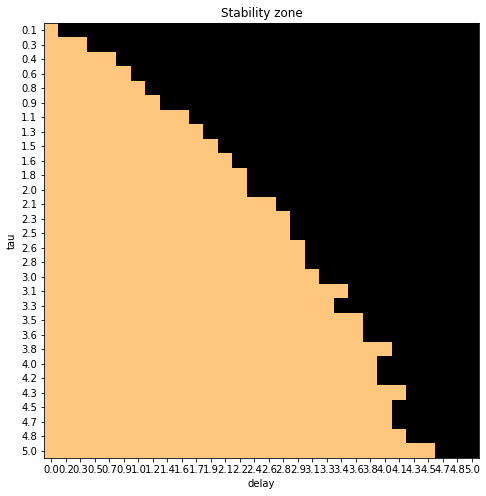

In [357]:
plot_stability(res, taus, delays)

Vous pouvez jouer sur les paramètres de PID pour voir la zone évoluer

## Perturbation extérieures

Et s'il y a du vent ? C'est là qu'intervient le dernier paramètre : `Kd`. Son rôle est de réagir aux perturbations extérieures avant qu'il n'y ait une trop grande déviation.  
Attention cependant, il est très sensible au bruit dans le signal d'entrée.

In [358]:
def calc_wind(i, wind_iteration):
    return np.exp(-(i - wind_iteration)**2 / 100)

In [359]:
def run_simulation_with_wind(model: Model, controller: PID, setpoint=1, wind_iteration = 700, iterations=1000):
    measure = 0
    dt = 0.1
    measures = []
    wind = 0
    
    for i in range(iterations):
        wind = calc_wind(i, wind_iteration)
        control = controller.get_control(setpoint, measure, dt)
        measure = model.update(control + wind, dt)
        measures.append(measure)
    return measures

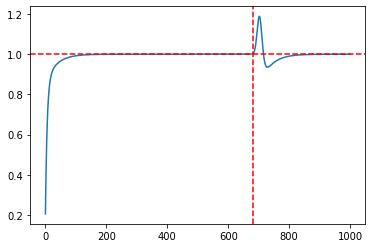

In [360]:
plt.plot(run_simulation_with_wind(FirstOrderModel(), PID(3, 0.1, 1)))
plt.axvline(680, color="red", linestyle='--')
plt.axhline(1, color="red", linestyle='--')

Jouez avec les paramètres du PID, en particulier le `Kd`, pour minimiser le dépassement dû au vent

# Test final

On va maintenant faire une simulation qui va inclure tout ce qu'on a vu précedemment.

**Trouvez les paramètres donnant le meilleur résultat**.

Notez :
 - le temps de réponse (convergence à 99%)
 - l'amplitude du premier dépassement
 - le nombre d'oscillations
 - vitesse maximale
 
⚠️ Contraintes : 
 - la vitesse max ne doit pas dépasser **0.05 unité / itération**
 - le système doit avoir convergé avant l'arrivée du vent (99% de la valeur objectif)

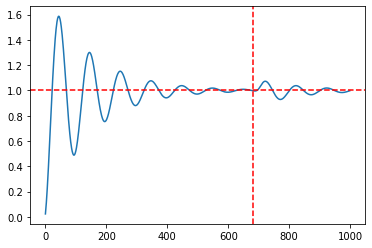

In [402]:
sim = run_simulation_with_wind(SecondOrderModel(), PID(9, 0.1, 50))
plt.plot(sim)
plt.axvline(680, color="red", linestyle='--')
plt.axhline(1, color="red", linestyle='--')

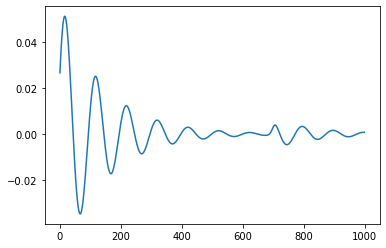

In [403]:
# Speed
plt.plot([sim[i+1] - sim[i] for i in range(len(sim)-1)])